# (TD Travaux dirigés) Dilated CNN model

In this notebook, we find
- preparation of time series data for training a Convolutional Neural Network (CNN) forecasting model
- data transformation in the required shape for the keras API

You will be asked to:
- implement a CNN model in keras to predict the next step ahead (time *t+1*) in the time series
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [45]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load data into Pandas dataframe

In [46]:
energy = pd.read_csv("data/data.csv",sep=";")
energy['Date'] = energy['Date'].astype(str) + " "+  energy['Hour'].astype(str)
energy['Date'] = pd.to_datetime(energy['Date'], format="%d/%m/%Y %H:%M:%S")
energy['load'] = energy['load'].astype(float)
energy = energy.set_index('Date')
energy.head()

,Hour,load
Date,,
2012-01-01 01:00:00,01:00:00,"2,698.00"
2012-01-01 02:00:00,02:00:00,"2,558.00"
2012-01-01 03:00:00,03:00:00,"2,444.00"
2012-01-01 04:00:00,04:00:00,"2,402.00"
2012-01-01 05:00:00,05:00:00,"2,403.00"


## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [47]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'


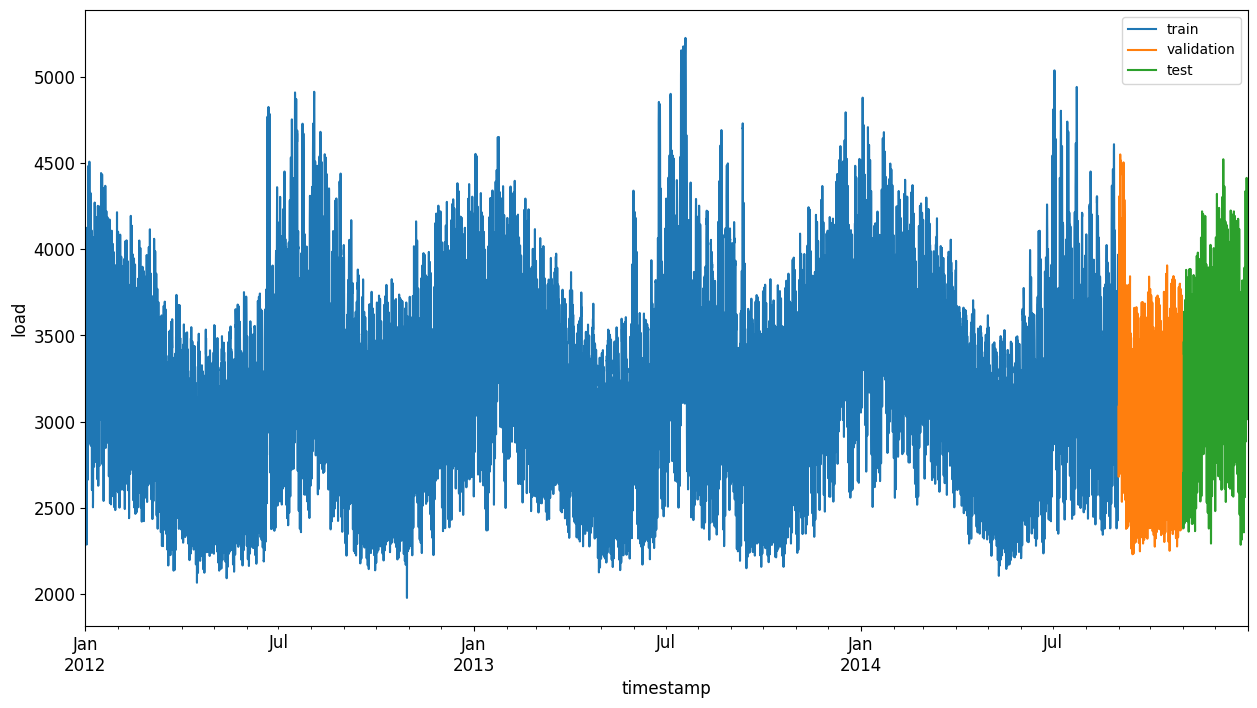

In [48]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [49]:
T = 4 # past values vindows
HORIZON = 1 #how many values we forecast

Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)
3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
4. Discard any samples with missing values
5. Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras

### 1. Filter the original dataset to include only that time period reserved for the training set
Create training set containing only the model features

In [50]:
train = energy.copy()[energy.index < valid_start_dt][['load']]
trainZNorm = energy.copy()[energy.index < valid_start_dt][['load']]

### 2. Scale the time series such that the values fall within the interval (0, 1)
Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [53]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
standardScaler = StandardScaler()
train['load'] = scaler.fit_transform(train)
trainZNorm['load'] = standardScaler.fit_transform(trainZNorm)


Original vs scaled data:

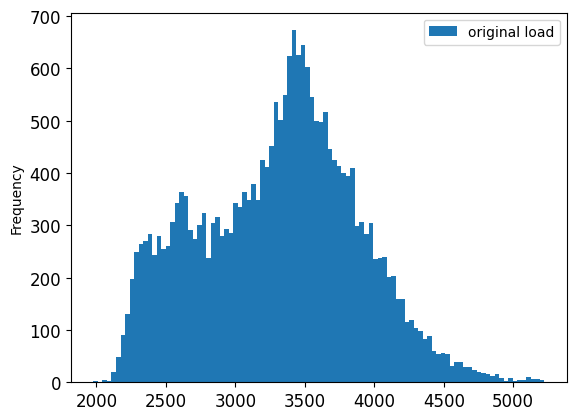

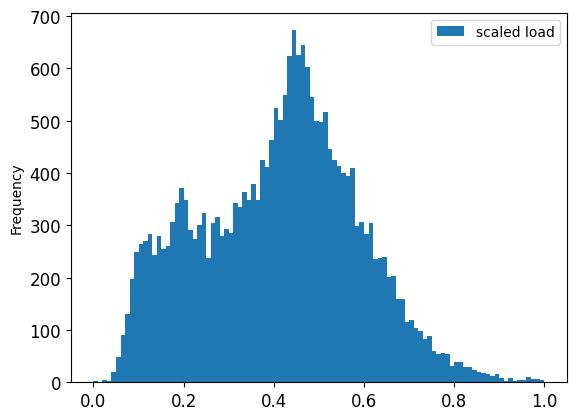

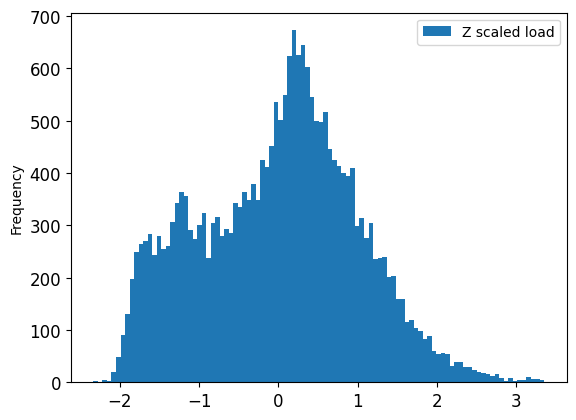

In [54]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
trainZNorm.rename(columns={'load':'Z scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

### 3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
First, we create the target (*y_t+1*) variable. If we use the convention that the dataframe is indexed on time *t*, we need to shift the *load* variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

In [55]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.tail(10)

,load,y_t+1
Date,,
2014-08-31 15:00:00,0.56,0.57
2014-08-31 16:00:00,0.57,0.58
2014-08-31 17:00:00,0.58,0.60
2014-08-31 18:00:00,0.60,0.61
2014-08-31 19:00:00,0.61,0.61
2014-08-31 20:00:00,0.61,0.58
2014-08-31 21:00:00,0.58,0.51
2014-08-31 22:00:00,0.51,0.43
2014-08-31 23:00:00,0.43,NaN


We also need to shift the load variable back T times to create the input sequence:

In [56]:
for t in range(1, T+1):
    train_shifted['load_t-'+str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

,load_original,y_t+1,load_t-3,load_t-2,load_t-1,load_t-0
Date,,,,,,
2012-01-01 01:00:00,0.22,0.18,NaN,NaN,0.20,0.22
2012-01-01 02:00:00,0.18,0.14,NaN,0.20,0.22,0.18
2012-01-01 03:00:00,0.14,0.13,0.20,0.22,0.18,0.14
2012-01-01 04:00:00,0.13,0.13,0.22,0.18,0.14,0.13
2012-01-01 05:00:00,0.13,0.15,0.18,0.14,0.13,0.13
2012-01-01 06:00:00,0.15,0.18,0.14,0.13,0.13,0.15
2012-01-01 07:00:00,0.18,0.23,0.13,0.13,0.15,0.18
2012-01-01 08:00:00,0.23,0.29,0.13,0.15,0.18,0.23
2012-01-01 09:00:00,0.29,0.35,0.15,0.18,0.23,0.29


### 4. Discard any samples with missing values
Notice how we have missing values for the input sequences for the first 5 samples. We will discard these:

In [57]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-3,load_t-2,load_t-1,load_t-0
Date,,,,,,
2012-01-01 03:00:00,0.14,0.13,0.20,0.22,0.18,0.14
2012-01-01 04:00:00,0.13,0.13,0.22,0.18,0.14,0.13
2012-01-01 05:00:00,0.13,0.15,0.18,0.14,0.13,0.13
2012-01-01 06:00:00,0.15,0.18,0.14,0.13,0.13,0.15
2012-01-01 07:00:00,0.18,0.23,0.13,0.13,0.15,0.18


### 5. Transform into a numpy arrays of shapes (samples, time steps, features) and (samples,1) for input into Keras
Now convert the target variable into a numpy array.

In [58]:
y_train = train_shifted[['y_t+1']].values

We now have a vector for target variable of shape:

In [35]:
y_train.shape

(23372, 1)

The target variable for the first 3 samples looks like:

Now convert the inputs into a numpy array with shape `(samples, time steps, features)`

In [59]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_train = X_train[... , np.newaxis]

The tensor for the input features now has the shape:

In [60]:
X_train.shape

(23372, 4, 1)

## Data preparation - validation set
Now we follow a similar process for the validation set. We keep *T* hours from the training set in order to construct initial features.

In [61]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
Date,
2014-08-31 21:00:00,"3,869.00"
2014-08-31 22:00:00,"3,643.00"
2014-08-31 23:00:00,"3,365.00"
2014-09-01 01:00:00,"2,886.00"
2014-09-01 02:00:00,"2,768.00"


Scale the series using the transformer fitted on the training set:

In [62]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
Date,
2014-08-31 21:00:00,0.58
2014-08-31 22:00:00,0.51
2014-08-31 23:00:00,0.43
2014-09-01 01:00:00,0.28
2014-09-01 02:00:00,0.24


Prepare validation inputs in the same way as the training set:

In [63]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].values
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid[..., np.newaxis]

In [64]:
y_valid.shape

(1463,)

In [65]:
X_valid.shape

(1463, 4, 1)

## Implement the Convolutional Neural Network
We want to implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

Use Adam optimizer and mean squared error as the loss function.

After training, pick and Load the model with the smallest loss

Plot training and validation losses

Compute the mean absolute percentage error (MAPE) over all predictions



In [66]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
FILTERS_NUMBER = 5
KERNEL_SIZE = 3
BATCH_SIZE = 32
EPOCHS = 10

## Evaluate the model
Create the test set

In [ ]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

Scale the test data

In [ ]:
test['load'] = scaler.transform(test)
test.head()

Create test set features

In [ ]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].values
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_test = X_test[... , np.newaxis]

Make predictions on test set

In [ ]:
#history = model.fit(....)
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
#load the weigths of the best model
model.load_weights("model_{:02d}.keras".format(best_epoch))
predictions = model.predict(X_test)
predictions

Compare predictions to actual load

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

Plot the predictions vs the actuals for the first week of the test set

In [ ]:
eval_df[eval_df.timestamp<'2014-11-08'].sort_values("timestamp").plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

clean up model files

In [ ]:
for m in glob('model_*.keras'):
    os.remove(m)